In [394]:
import pandas as pd
import seaborn as sns
import numpy as np

In [395]:
# Load links data
links_df = pd.read_csv('./data/links.csv')

# Load movies data
movies_df = pd.read_csv('./data/movies.csv')

# Load ratings data
ratings_df = pd.read_csv('./data/ratings.csv')

### Get important Movies genres

In [396]:
movies_df.genres = movies_df.genres.str.split('|')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]"


In [397]:
genre_count = movies_df['genres'].explode().value_counts().reset_index()
genre_count.columns = ['genre', 'count']
genre_count = genre_count[genre_count["count"] > movies_df.size/100]
selected_genres = genre_count['genre'].tolist()
selected_genres

['Drama',
 'Comedy',
 'Thriller',
 'Action',
 'Romance',
 'Adventure',
 'Crime',
 'Sci-Fi',
 'Horror',
 'Fantasy',
 'Children',
 'Animation',
 'Mystery',
 'Documentary',
 'War',
 'Musical']

### Calculate users average rating for selected genres

In [398]:
users = pd.DataFrame(ratings_df['userId'].unique(), columns=['userId'])
ratings = pd.merge(movies_df, ratings_df, on='movieId')
for genre in selected_genres:
    genre_ratings = ratings[ratings['genres'].apply(lambda x: genre in x)]
    users[f"{genre}"] = users.apply(lambda x: genre_ratings[genre_ratings['userId'] == x['userId']]['rating'].mean(), axis=1)
users

,userId,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Sci-Fi,Horror,Fantasy,Children,Animation,Mystery,Documentary,War,Musical
0,1,4.529412,4.277108,4.145455,4.322222,4.307692,4.388235,4.355556,4.225000,3.470588,4.297872,4.547619,4.689655,4.166667,NaN,4.500000,4.681818
1,2,3.882353,4.000000,3.700000,3.954545,4.500000,4.166667,3.800000,3.875000,3.000000,NaN,NaN,NaN,4.000000,4.333333,4.500000,NaN
2,3,0.750000,1.000000,4.142857,3.571429,0.500000,2.727273,0.500000,4.200000,4.687500,3.375000,0.500000,0.500000,5.000000,NaN,0.500000,0.500000
3,4,3.483333,3.509615,3.552632,3.320000,3.379310,3.655172,3.814815,2.833333,4.250000,3.684211,3.800000,4.000000,3.478261,4.000000,3.571429,4.000000
4,5,3.800000,3.466667,3.555556,3.111111,3.090909,3.250000,3.833333,2.500000,3.000000,4.142857,4.111111,4.333333,4.000000,NaN,3.333333,4.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,3.787966,3.565321,3.525126,3.178808,3.740845,3.503401,3.654135,3.556962,3.346154,3.597938,3.448980,3.714286,3.791209,3.800000,3.792308,3.727273
606,607,4.012195,3.327273,4.114754,3.722222,3.517241,3.466667,3.814815,3.250000,4.114286,3.571429,3.421053,3.333333,4.647059,NaN,4.166667,3.600000
607,608,3.437500,2.736620,3.536680,3.330325,2.886792,3.220994,3.613014,3.296407,3.319588,3.000000,2.460227,3.118182,3.550725,3.000000,3.578947,2.757576
608,609,3.368421,3.285714,3.285714,3.090909,3.200000,3.200000,3.500000,3.000000,3.500000,3.000000,3.000000,3.000000,NaN,3.000000,3.500000,NaN


<Axes: >

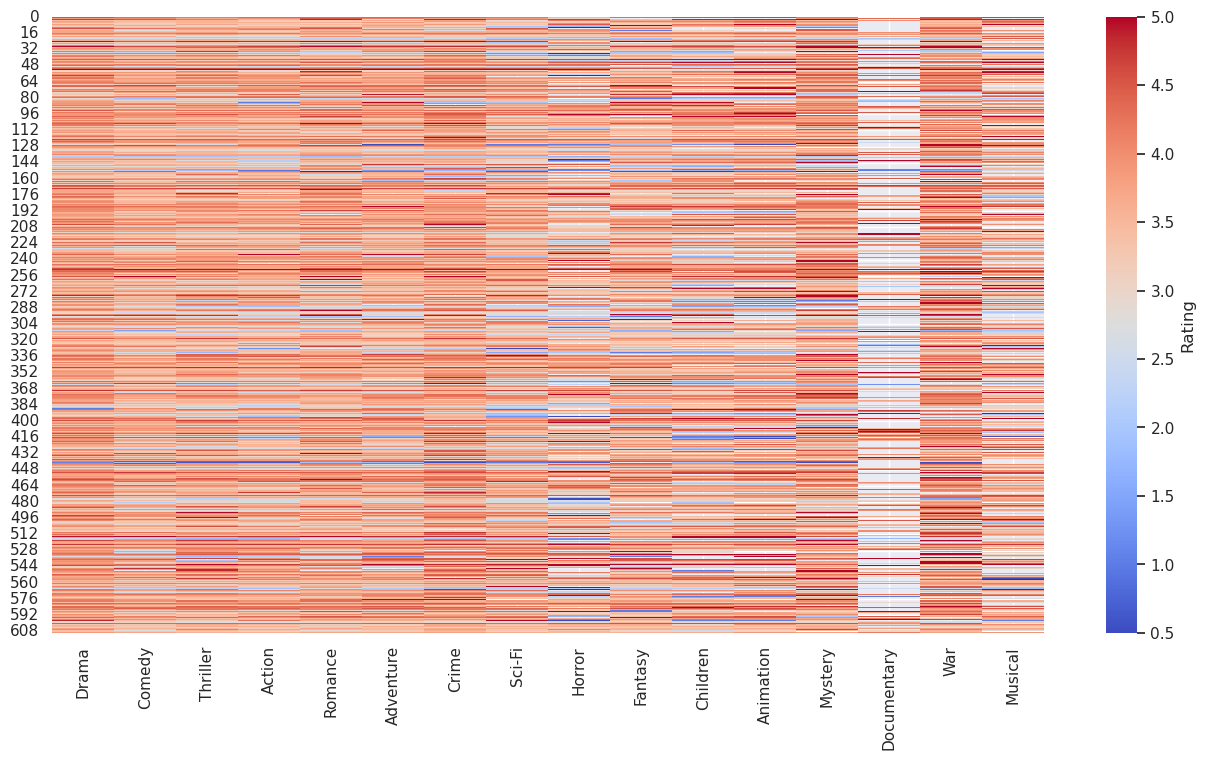

In [399]:
sns.set_theme(rc={'figure.figsize':(16,8)})
sns.heatmap(users.drop(["userId"], axis=1), cmap='coolwarm', cbar_kws={'label': 'Rating'})

### Cluster users with respect to average rating for selected genres

In [442]:
from sklearn.cluster import KMeans

In [443]:
users = users.fillna(4)

In [444]:
def getKMeansError(data, k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    return kmeans.inertia_

In [479]:
def plotError(data, start = 10, max_k=10, step = 1):
    errors = []
    for k in range(start, max_k, step):
        errors.append(getKMeansError(data, k))
    xticks = np.arange(start, max_k, step)
    errors_df = pd.DataFrame(np.array([errors, xticks]).T, columns=["errors", "xticks"])
    errors_df.plot(title="KMeans error", x="xticks", y="errors")

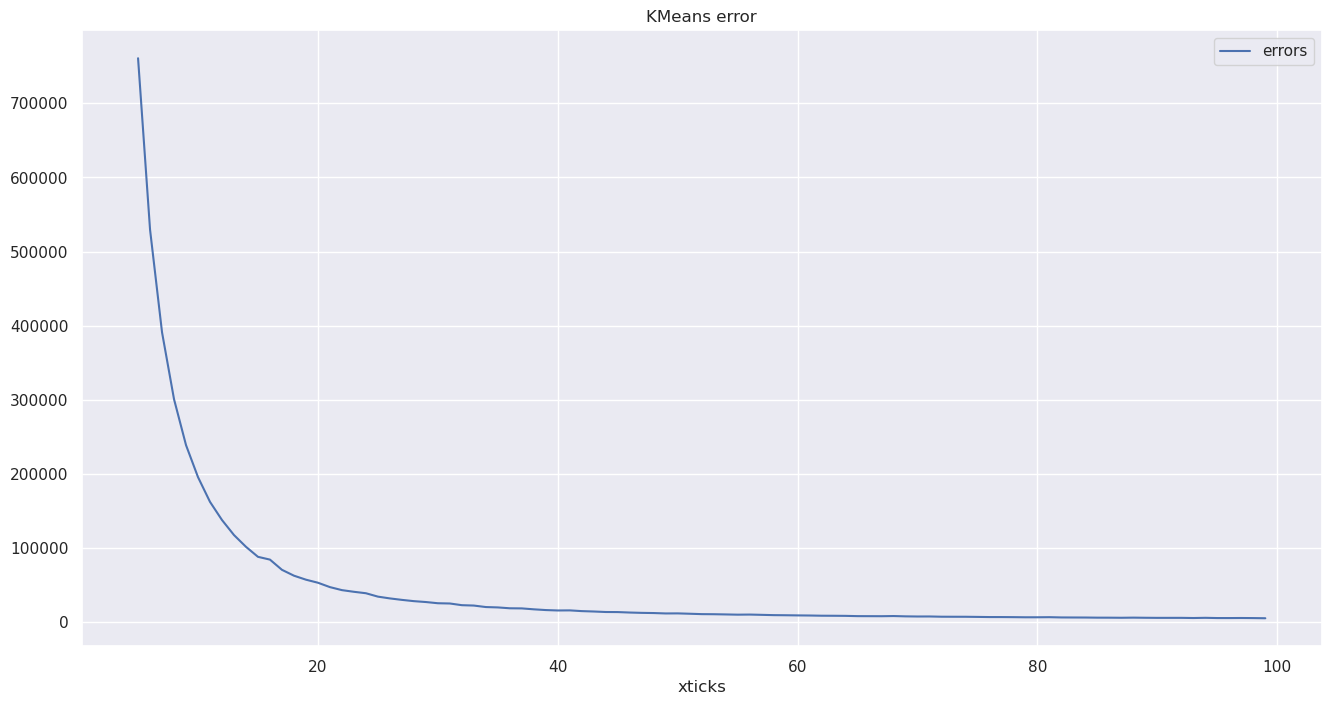

In [480]:
plotError(users, start = 5, max_k = 100, step = 1)

In [486]:
kmeans = KMeans(n_clusters=50)
usersCluster = kmeans.fit(users)
users['cluster'] = usersCluster.labels_
users

,userId,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Sci-Fi,Horror,Fantasy,Children,Animation,Mystery,Documentary,War,Musical,cluster
0,1,4.529412,4.277108,4.145455,4.322222,4.307692,4.388235,4.355556,4.225000,3.470588,4.297872,4.547619,4.689655,4.166667,3.500000,4.500000,4.681818,7
1,2,3.882353,4.000000,3.700000,3.954545,4.500000,4.166667,3.800000,3.875000,3.000000,3.500000,3.500000,3.500000,4.000000,4.333333,4.500000,3.500000,7
2,3,0.750000,1.000000,4.142857,3.571429,0.500000,2.727273,0.500000,4.200000,4.687500,3.375000,0.500000,0.500000,5.000000,3.500000,0.500000,0.500000,7
3,4,3.483333,3.509615,3.552632,3.320000,3.379310,3.655172,3.814815,2.833333,4.250000,3.684211,3.800000,4.000000,3.478261,4.000000,3.571429,4.000000,7
4,5,3.800000,3.466667,3.555556,3.111111,3.090909,3.250000,3.833333,2.500000,3.000000,4.142857,4.111111,4.333333,4.000000,3.500000,3.333333,4.400000,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,3.787966,3.565321,3.525126,3.178808,3.740845,3.503401,3.654135,3.556962,3.346154,3.597938,3.448980,3.714286,3.791209,3.800000,3.792308,3.727273,19
606,607,4.012195,3.327273,4.114754,3.722222,3.517241,3.466667,3.814815,3.250000,4.114286,3.571429,3.421053,3.333333,4.647059,3.500000,4.166667,3.600000,19
607,608,3.437500,2.736620,3.536680,3.330325,2.886792,3.220994,3.613014,3.296407,3.319588,3.000000,2.460227,3.118182,3.550725,3.000000,3.578947,2.757576,19
608,609,3.368421,3.285714,3.285714,3.090909,3.200000,3.200000,3.500000,3.000000,3.500000,3.000000,3.000000,3.000000,3.500000,3.000000,3.500000,3.500000,19
